In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mapclassify
from sklearn.neighbors import KDTree
import folium
import requests
import datetime as dt
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import copy
plt.rcParams['figure.figsize'] = 10, 8
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from sodapy import Socrata
from folium import plugins
from folium.plugins import HeatMap

In [3]:
!pwd

/Users/juliatuvaleva/Documents/pycon-2019/pycon-2019


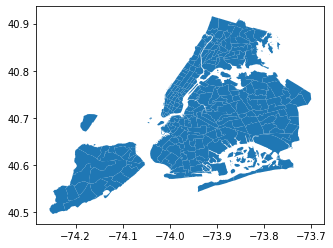

In [4]:
taxizone = gpd.read_file('NYC_Taxi_Zones.geojson')
taxizone.plot();

In [ ]:
%%time
client = Socrata("data.cityofnewyork.us", None)
results = client.get("biws-g3hs", 
                     where = 'tpep_pickup_datetime between \
                         \'2017-03-13T00:00:00.000\' and \'2017-03-20T00:00:00.000\'',
                     limit=800000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [ ]:
%%time
results_df['pickup_time'] = results_df['tpep_pickup_datetime'].apply(lambda x: 
                                                                     dt.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f"))

results_df['dropoff_time'] = results_df['tpep_dropoff_datetime'].apply(lambda x: 
                                                                     dt.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%f"))

results_df['pickup_time30'] = results_df['pickup_time'].dt.floor('30min').astype(str) 
results_df['dropoff_time30'] = results_df['dropoff_time'].dt.floor('30min').astype(str)

In [ ]:
results_df.head()

In [5]:
yellow_taxi = pd.read_csv('yellow_tripdata_2016-03.csv')

In [6]:
%%time
yellow_taxi['day'] = yellow_taxi['tpep_pickup_datetime'].\
                                apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)

CPU times: user 2min 10s, sys: 961 ms, total: 2min 11s
Wall time: 2min 12s


In [ ]:
#-74.046951,40.595539,-73.739292,40.842227

In [31]:
week_sample = yellow_taxi[yellow_taxi['day']==15]

week_sample = week_sample[((week_sample['pickup_longitude']>-74.046951)&
                           (week_sample['pickup_longitude']<-73.739292))&
                          ((week_sample['pickup_latitude']>40.595539)&
                           (week_sample['pickup_latitude']<40.842227))]
week_sample.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,day
3368868,1,2016-03-15 00:00:00,2016-03-15 00:04:27,1,1.40,-73.913078,40.769222,1,N,-73.886589,40.764839,1,6.0,0.5,0.5,1.82,0.00,0.3,9.12,15
3368869,2,2016-03-15 00:00:00,2016-03-15 00:18:41,5,6.07,-73.994034,40.751141,1,N,-73.945358,40.716576,1,20.5,0.5,0.5,5.47,5.54,0.3,32.81,15
3368870,1,2016-03-15 00:00:01,2016-03-15 00:07:23,1,1.20,-73.993362,40.741558,1,N,-73.978539,40.745277,1,7.0,0.5,0.5,1.65,0.00,0.3,9.95,15
3368871,1,2016-03-15 00:00:01,2016-03-15 00:17:01,1,4.70,-74.013878,40.713848,1,N,-73.981537,40.677589,1,17.0,0.5,0.5,3.65,0.00,0.3,21.95,15
3368872,2,2016-03-15 00:00:01,2016-03-15 00:23:31,2,10.90,-73.874580,40.774090,1,N,-73.984787,40.768532,1,32.0,0.5,0.5,7.77,5.54,0.3,46.61,15


In [32]:
len(week_sample)

377811

In [33]:
week_sample['lat'] = np.round(week_sample['pickup_latitude'].astype(float), 3)
week_sample['lon'] = np.round(week_sample['pickup_longitude'].astype(float), 3)

In [ ]:
m = folium.Map(location=[40.746128, -74.004265], 
               zoom_start=10,
               tiles = "CartoDB positron")
               

In [34]:
df_for_heatmap = week_sample[['lat', 'lon']].drop_duplicates()
df_for_heatmap = df_for_heatmap.dropna(axis=0, subset=['lat','lon'])

In [35]:
len(df_for_heatmap)

7104

In [ ]:
# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lon']] for index, row in df_for_heatmap.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        radius=7).add_to(m)

# Display the map
m

In [36]:
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans

In [37]:
X = df_for_heatmap[['lat', 'lon']].values

In [38]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

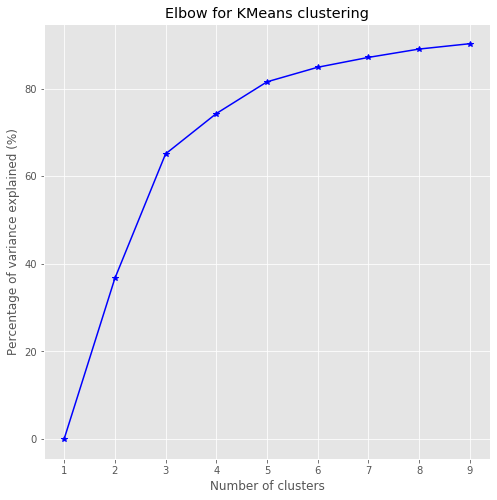

In [39]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

In [40]:
def plot_stations_map(ax, stns):
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates       
        ax.scatter(df['lon'], df['lat'], marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

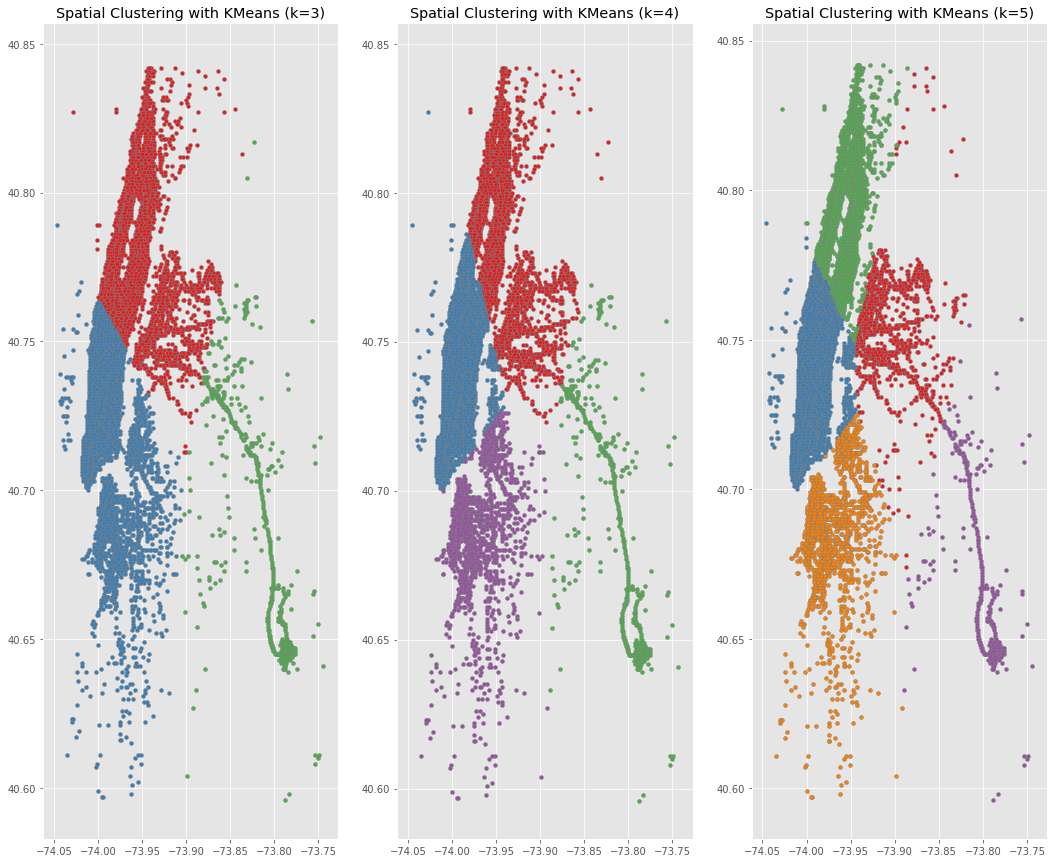

In [42]:
k = [3, 4, 5]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df_for_heatmap['cluster'] = est.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_stations_map(ax, df_for_heatmap)


In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

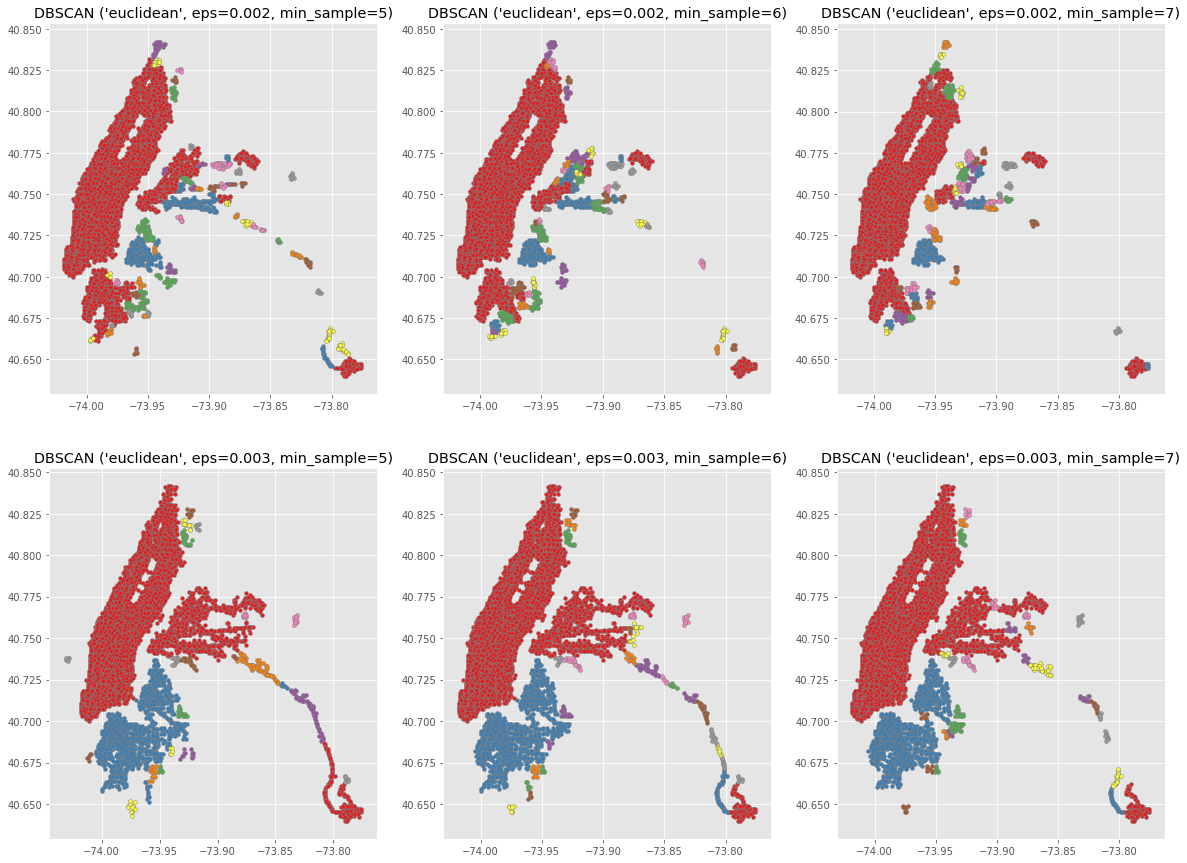

In [51]:
eps = [0.002, 0.003]   # unit: latitude/longitude
min_sample = [4,5,6,7]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))


for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        df_for_heatmap['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df_for_heatmap)

In [ ]:
precise_matches.head()

df_clst = precise_matches[['pickup_longitude','pickup_latitude']]

df_clst['lat'] = np.round(df_clst['pickup_latitude'].astype(float), 4)
df_clst['lon'] = np.round(df_clst['pickup_longitude'].astype(float), 4)
df_clst = df_clst.drop_duplicates(subset=['lat','lon'])
X = df_clst[['lat', 'lon']].drop_duplicates().values

Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

def plot_stations_map(ax, stns, lon, lat):
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates       
        ax.scatter(df[lon], df[lat],
                   marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

k = [4, 5, 6]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df_clst['cluster'] = est.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_stations_map(ax, df_clst, 'pickup_longitude', 'pickup_latitude')

eps = [0.002, 0.003]   # unit: latitude/longitude
min_sample = [5,6,7,10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))


for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        df_clst['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df_clst,
                          'pickup_longitude', 'pickup_latitude')



eps = [0.002, 0.003]
n1 = len(eps)
n2 = 1

plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
for i in range(n1):
    est = DBSCAN(eps=eps[i], min_samples=10, metric="euclidean").fit(X)
    df_clst['cluster'] = est.labels_.tolist()

    ax = plt.subplot(n2, n1, n2*i+1)
    ax.set_title("DBSCAN ('euclidean', eps={}, min_sample=10)".format(eps[i]))
        
    plot_stations_map(ax, df_clst,
                          'pickup_longitude', 'pickup_latitude')

est1 = DBSCAN(eps=0.002, min_samples=10, metric="euclidean").fit(X)
est2 = DBSCAN(eps=0.003, min_samples=10, metric="euclidean").fit(X)
df_clst['cluster_1'] = est1.labels_.tolist()
df_clst['cluster_2'] = est2.labels_.tolist()

df_clst = df_clst.reset_index()
df_clst.head()

f = {'pickup_longitude':'mean',
     'pickup_latitude':'mean',
      'index':'count'}

df_clst1 = df_clst.groupby('cluster_1').agg(f).reset_index()

df_clst1.head()

df_clst1 = df_clst.groupby('cluster_2').agg(f).reset_index()

df_clst1.head()

m = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles='cartodbpositron')

for i in range(0,len(df_clst1)):
   folium.Circle(
      location=[df_clst1.iloc[i]['pickup_latitude'], df_clst1.iloc[i]['pickup_longitude']],
      popup= 'Count of pickup:\n ' + df_clst1.iloc[i]['index'].astype(int).astype(str),
      radius=((df_clst1.iloc[i]['index'])**0.8)*np.log10(df_clst1.iloc[i]['index']),
      color='purple',
      fill=True,
      fill_color='purple'
   ).add_to(m)
 
m

